In [1]:
from src.models.baselinecnn import Conv1dNet
from src.dataset.dataset import AudioDataset
from src.models.utils import model_map

import thop
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings

# turn off the UserWarnings because lots of them are talking about 
# library function refactoring, last or future deprecations
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
def generate_input_sample():
    dataset = AudioDataset(
            os.path.join("./data", "train/manifest_train.csv"),
            sample_rate=16000,
            n_fft=400,
            hop_length=256,
            win_length=400,
            n_mels=64
        )
    
    for mel_spec, _ in dataset:
        sample_input = mel_spec
        break
    sample_input = sample_input[None, :, :]
    
    return sample_input

In [3]:
def check_model_parameters(model, input_sample):
    macs, params = thop.profile(
        # here we have to use a backbone model with classification head, not a pytorch loghtning wrapper
        model, 
        inputs=(input_sample,),
    )
    return macs, params

In [4]:
def is_model_suit(model, model_name="new_model"):
    sample_input = generate_input_sample()
    macs, params = check_model_parameters(model, sample_input)
    
    is_suit = macs <= 1e6 and params <= 1e4
    
    print("="*20)
    print(f"MODEL: {model_name}")
    print(f"\tNUM PARAMETERS: {params}")
    print(f"\tNUM MACs: {macs}")
    print(f"IS MODEL SUIT: {is_suit}")
    return is_suit

In [46]:
def plot_label_distribution(labels, top_n=None, palette="Set2"):
    """
    Build a beautiful seaborn bar plot showing the distribution of labels.
    
    Parameters:
        labels (list/array-like): Array of labels (e.g., strings or ints).
        top_n (int or None): If set, show only top N most frequent labels.
        palette (str or list): Seaborn palette name or list of colors.
    """
    # Create frequency table
    s = pd.Series(labels)
    counts = s.value_counts()
    if top_n is not None:
        counts = counts.head(top_n)
    
    df = counts.reset_index()
    df.columns = ["label", "count"]
    df["percent"] = df["count"] / df["count"].sum() * 100
    
    # Aesthetics
    sns.set_theme(style="whitegrid", context="talk")
    num_cats = len(df)
    fig_w = max(6, num_cats * 0.7)
    fig_h = 6
    
    # Plot
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    sns.barplot(
        data=df,
        x="label", y="count",
        palette=palette,
        ax=ax
    )
    
    # Annotate bars with counts and %s
    for i, p in enumerate(ax.patches):
        count = df.loc[i, "count"]
        pct = df.loc[i, "percent"]
        ax.annotate(
            f"{count} ({pct:.1f}%)",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center", va="bottom",
            fontsize=11, color="#333",
            xytext=(0, 5), textcoords="offset points"
        )
    
    # Tidy up axes
    ax.set_title("Распределение меток", pad=15)
    ax.set_xlabel("Метка")
    ax.set_ylabel("Количество")
    
    # Rotate x labels if many categories
    if num_cats > 8:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
    
    # Improve layout
    plt.tight_layout()
    plt.show()

In [5]:
models_params = {}
sample_input = generate_input_sample()

for model_name, model_class in model_map.items():
    model = model_class(num_classes=5)
    macs, params = check_model_parameters(model, sample_input)
    
    models_params[model_name] = (params, macs)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_adap_avgpool() for <class

In [6]:
for model_name, model_params in models_params.items():
    params, macs = model_params
    print("="*20)
    print(f"MODEL: {model_name}")
    print(f"\tNUM PARAMETERS: {params}")
    print(f"\tNUM MACs: {macs}")
    print(f"IS MODEL SUIT: {macs <= 1e6 and params <= 1e4}")

MODEL: resnet18
	NUM PARAMETERS: 11172805.0
	NUM MACs: 142439424.0
IS MODEL SUIT: False
MODEL: squeezenet1_0
	NUM PARAMETERS: 728581.0
	NUM MACs: 41473938.0
IS MODEL SUIT: False
MODEL: mobilenet_v3_small
	NUM PARAMETERS: 1522693.0
	NUM MACs: 5692472.0
IS MODEL SUIT: False
MODEL: micro_cnn
	NUM PARAMETERS: 1105.0
	NUM MACs: 51696.0
IS MODEL SUIT: True
MODEL: nano_cnn
	NUM PARAMETERS: 499.0
	NUM MACs: 25072.0
IS MODEL SUIT: True
MODEL: tiny_cnn
	NUM PARAMETERS: 2701.0
	NUM MACs: 113600.0
IS MODEL SUIT: True
MODEL: baseline
	NUM PARAMETERS: 12133.0
	NUM MACs: 256464.0
IS MODEL SUIT: False


In [49]:
df = pd.read_csv(os.path.join("./data", "train/manifest_train.csv"))
labels = df['label'].to_list()

/tmp/ipykernel_12143/1281700861.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


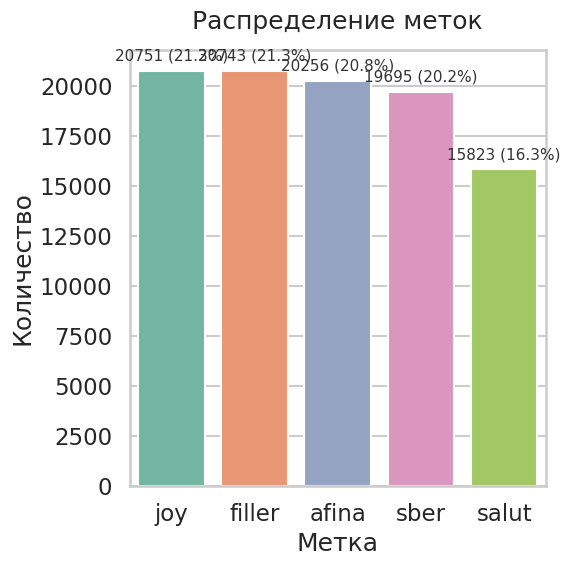

In [50]:
plot_label_distribution(labels)

In [51]:
df = pd.read_csv(os.path.join("./data", "train/manifest_val.csv"))
labels = df['label'].to_list()

/tmp/ipykernel_12143/1281700861.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


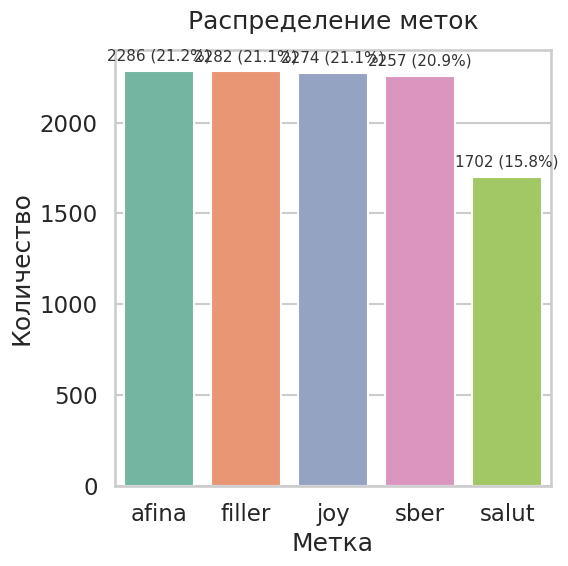

In [52]:
plot_label_distribution(labels)

In [53]:
from src.models.baselinecnn import Conv1dNet

In [54]:
is_model_suit(Conv1dNet(num_classes=5), model_name="Conv1dNet")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MODEL: Conv1dNet
	NUM PARAMETERS: 12421.0
	NUM MACs: 1892784.0
IS MODEL SUIT: False


False

In [ ]:
from utils import check_params
from sklearn.model_selection import ParameterGrid

In [ ]:
errors = check_params(
        sample_rate=16000,
        n_fft=400,
        win_length=256,
        hop_length=256,
        n_mels=64
    )

if len(errors) > 0:
    for error in errors:
        print(f"Ошибка: {error}")
else:
    print("Все параметры корректны!")

In [ ]:
def check_model_parameters(sample_rate, n_fft, win_length, hop_length, n_mels):
    errors = check_params(
        sample_rate=16000,
        n_fft=400,
        win_length=256,
        hop_length=256,
        n_mels=64
    )
    return len(errors) == 0

In [ ]:
grid = {
    "sample_rate": [2000**rate_pow for rate_pow in range(5)],
    "n_fft": [n for n in range(200, 800+1, 200)],
    "hop_length": [2**p for p in range(7, 10+1)],
    "win_length": [n for n in range(200, 800+1, 200)],
    "n_mels": [2**p for p in range(4, 7+1)]
}

valid_param_combinations = [p for p in ParameterGrid(grid) if check_model_parameters(p)]

In [ ]:
import os
import wave
import contextlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [ ]:
manifest_path = Path("./data/train/manifest_train.csv")

file_list = []
manifest_df = pd.read_csv(manifest_path)

file_list = manifest_df.path

durations = []
for file in file_list:
    file_path = manifest_path / Path(file)

    with contextlib.closing(wave.open(file_path, 'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        durations.append({"duration": duration})

In [ ]:
# В DataFrame для удобства
df = pd.DataFrame(durations)

# Столбчатая диаграмма распределения
plt.figure(figsize=(10, 6))
sns.histplot(df["duration"], bins=20, kde=False)
plt.xlabel("Длительность (секунды)")
plt.ylabel("Количество файлов")
plt.title("Распределение длительности WAV файлов")
plt.show()